# Example: Creating parametric families #1

In [1]:
import math

import matplotlib.pyplot as plt

from pysatl_core.distributions import (
    DefaultComputationStrategy,
    DefaultSamplingUnivariateStrategy,
)
from pysatl_core.families import (
    ParametricFamily,
    ParametricFamilyRegister,
    constraint,
    parametrization,
)
from pysatl_core.types import UnivariateContinuous

PDF = "pdf"
CDF = "cdf"
PPF = "ppf"

Let's create lognormal family of random variables, by providing PDF

In [2]:
def lognormal_pdf(parameters, x: float) -> float:
    if x <= 0:
        return 0.0
    return (
        1.0
        / (x * parameters.sigma * math.sqrt(2.0 * math.pi))
        * math.exp(-((math.log(x) - parameters.mu) ** 2) / (2 * parameters.sigma**2))
    )

Now let's create an object, that will represent our family

In [3]:
Lognormal = ParametricFamily(
    name="Lognormal Family",
    distr_type=UnivariateContinuous,
    distr_parametrizations=["canonical", "meanvar"],
    distr_characteristics={PDF: lognormal_pdf},
    sampling_strategy=DefaultSamplingUnivariateStrategy(),
    computation_strategy=DefaultComputationStrategy(),
)

We specified that there will be two parametrizations: canonical (which will be treat as base) and mean-var. Let's introduce them

In [4]:
@parametrization(family=Lognormal, name="canonical", base=True)
class NormalParametrization:
    mu: float
    sigma: float

    @constraint(description="sigma > 0")
    def check_sigma_positive(self) -> bool:
        return self.sigma > 0


@parametrization(family=Lognormal, name="meanvar")
class MeanVarParametrization:
    mean: float
    var: float

    @constraint(description="mean > 0")
    def check_mean_positive(self) -> bool:
        return self.mean > 0

    @constraint(description="var > 0")
    def check_var_positive(self) -> bool:
        return self.var > 0

    def transform_to_base_parametrization(self) -> NormalParametrization:
        mu = math.log(self.mean**2 / math.sqrt(self.mean**2 + self.var))
        sigma = math.sqrt(math.log(1 + self.var / self.mean**2))
        return NormalParametrization(mu=mu, sigma=sigma)

Note that for second parametrization we provided way convert it to base one. Now, let's register our family and do some things:

In [5]:
ParametricFamilyRegister.register(Lognormal)
dist = Lognormal(mean=1.0, var=1.0, parametrization_name="meanvar")
cdf = dist.computation_strategy.query_method(CDF, dist)
pdf = dist.computation_strategy.query_method(PDF, dist)
ppf = dist.computation_strategy.query_method(PPF, dist)

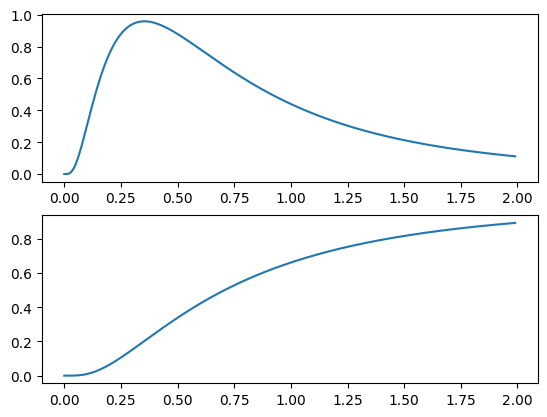

In [6]:
delta_t = 0.01
x_max = 2
x = [i * delta_t for i in range(int(x_max / delta_t))]
y_pdf = [pdf(xx) for xx in x]
y_cdf = [cdf(xx) for xx in x]
fig, ax = plt.subplots(2, 1)
ax[0].plot(x, y_pdf)
ax[1].plot(x, y_cdf)

In [7]:
base_parameters = Lognormal.parametrizations.get_base_parameters(dist.parameters)
y_true_pdf = [lognormal_pdf(base_parameters, xx) for xx in x]
print(max([y_true_pdf[i] - y_pdf[i] for i in range(len(x))]))

0.0
